# PHYS 641 Assignment 2 
### Andrew V. Zwaniga (260843983) 
#### Due October 3 2018

### Problem 1: $QR$ Factorization 

Consider a dataset $\mathbf{d}$ and a model $A$ with fit parameters $\mathbf{m}$ such that $\langle\mathbf{d}\rangle = A\mathbf{m}$. The __condition number__ of $A$ is given by 

$ \kappa(A) = \|A^{-1}\| \cdot \|A\| $

where $\|A\| = \max_{\|\mathbf{x}\|=1}\|A\mathbf{x}\|$ is the __spectral norm__ of $A$. Thus the spectral norm is a measure of the maximum deformation that a matrix makes of the unit ball. (By linearity any ball of radius 1 will do, so we choose the one centered on the origin.) It can be shown that (proof omitted for relevancy) the spectral norm is in fact a norm (according to the metric space definition) and that it also satisfies the following multiplicativity inequality: 

$ \|AB\| \leq \|A\|\|B\| $. 

Furthermore, it can be shown that the spectral norm is trace-invariant. 

The linear least squares solution is 

$ \mathbf{m} = (A^{T}N^{-1}A)^{-1}A^{T}N^{-1}\mathbf{d}~~~~~~(*)$ 

with 

$ \langle\mathbf{d}\rangle = A\mathbf{m}~~~~~~(**)$

From here we observe that the matrix on the RHS of the above equation will involve squaring the condition number, which, if $A$ is "close to being singular", will conceivably result in a practical infinity, or otherwise a number too large for a code to handle safely and/or quickly. This is because the spectral norm satisfies the multiplicativity inequality previously mentioned, so 

$ \|(A^{T}N^{-1}A)^{-1}A^{T}N^{-1}\| \leq \|(A^{T}N^{-1}A)^{-1}\|~\|A^{T}\|~\|N^{-1}\| 
                                        = \|A^{-1}\|~\|A\|~\|A^{-1}\|~\|A\|~\|N\|~\|N^{-1}\|$
                                        
This shows that the LLS solution, as we have written it, may be intractible in practice. 

It is possible to alleviate the situation with at least two different methods, both involving the decomposition of $A$. The first is the so-called __singular value decomposition__ (SVD) for which we write $A = USV^{T}$ where $U$ is an orthogonal rectangular matrix, $S$ is a diagonal matrix having the so-called __singular values__ of $A$ along its diagonal, and $V$ is an orthogonal square matrix. This SVD decomposition leads to the solution $ SV^{T}\mathbf{m} = U^{T}\mathbf{d}$. The second method is written as $A = QR$ where $Q$ is an orthogonal rectangular matrix and $R$ is an upper-triangular matrix.  

Given equation $(*)$ the QR decomposition leads to 

$ \mathbf{m} = ((QR)^{T}N^{-1}(QR))^{-1}(QR)^{T}N^{-1}\mathbf{d}$

$ \iff \mathbf{m} = (R^{T}Q^{T}N^{-1}QR)^{-1}R^{T}Q^{T}N^{-1}\mathbf{d}$

If $R$ is invertible (i.e. has no zero values along its diagonal) then so is $R^{T}$, thus 

$ \iff \mathbf{m} = R^{-1}(Q^{T}N^{-1}Q)^{-1}Q^{T}N^{-1}\mathbf{d}~~~~~~(***)$ 

__Remark:__ Theorem 1 in http://www.math.drexel.edu/~foucart/TeachingFiles/F12/M504Lect3.pdf guarantees that $R$ is invertible when $A$ is square. If $A$ is not square, Theorem 2 still guarantees the existence and uniqueness of the QR decomposition but only tells us that $R$ is upper triangular - not necessarily invertible. 

Equation $(***)$ can be used for a general noise matrix $N$. In the simplified case that $N$ is proportional to identity then it cancels and we get 

$ \mathbf{m} = R^{-1}(R^{T})^{-1}R^{T}Q^{T}\mathbf{d} $

$ \iff \mathbf{m} = R^{-1}Q^{T}\mathbf{d} $ 

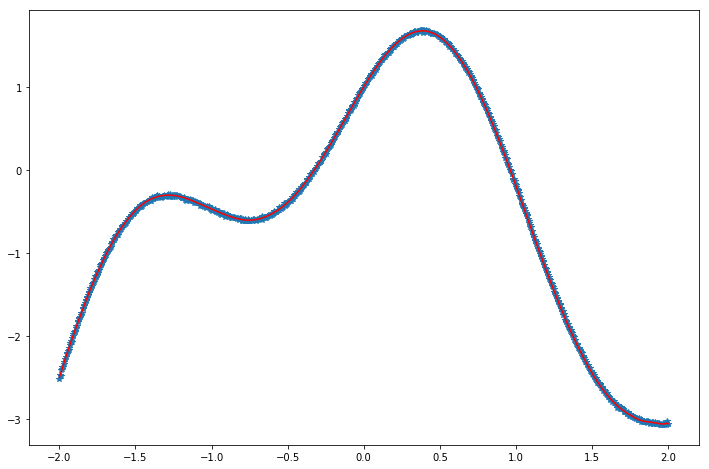

In [292]:
### Problem 1

## Fit routine using polynomials and the QR decomposition 

import time
import numpy as np 
from matplotlib import pyplot as plt 

nsamp  = 1000
left   = -2
right  = 2
x  = np.linspace(left,right,nsamp)

y_true      = np.sin(3*x) + np.exp(-x**2) - 0.7*x**2
poly_string = "$\sin(3x) + \exp(-x^{2}) - 0.7x^{2}$" 

noise  = 0.01
y      = y_true + np.random.randn(nsamp)*noise

dmax   = 50 # max degree for polynomial fits 

dd = np.arange(1,dmax,1)

QR_rms_vec  = np.zeros(len(dd))
SVD_rms_vec = np.zeros(len(dd))
std_rms_vec = np.zeros(len(dd)) 
rats        = np.zeros(len(dd)) 

for d in range(1,dmax):
    
    A      = np.zeros([nsamp, d+1])
    A[:,0] = 1.0 # zeroth order term 
    
    for i in range(d): 
        A[:,i+1] = A[:,i]*x
        
    ############# QR factorization ###############    
    
    t1 = time.clock()
    
    Q,R = np.linalg.qr(A)
    
    #Rt     = R.transpose()
    Qt     = Q.transpose()
    
    R_i = np.linalg.inv(R)
    
    #RtR    = np.dot(Rt, R)
    #RtQt   = np.dot(Rt, Qt)
    
    #RtR_i  = np.linalg.inv(RtR)
    
    #m_QR   = np.dot(RtR_i, np.dot(RtQt,y))
    
    m_QR = np.dot(R_i, np.dot(Qt,y))
    
    QR_fit = np.dot(A, m_QR)
    QR_rms = np.std(QR_fit - y_true)
    
    #print("QR took " + str(time.clock() - t1) + " s") 
    
    ########### SVD factorization ###################
    
    t2 = time.clock() 
    
    U,S,V = np.linalg.svd(A,0)
    
    Utd  = np.dot(U.transpose(), y)
    SUtd = Utd/S
    Vt  = V.transpose()
    
    m_SVD = np.dot(Vt, SUtd)
    
    SVD_fit = np.dot(A, m_SVD)
    SVD_rms = np.std(SVD_fit - y_true)
    
    #print("SVD took " + str(time.clock() - t2) + " s") 
    
    ########### Standard method ####################
    
    t3 = time.clock()
    
    At    = A.transpose() 
    AtA   = np.dot(At, A)
    AtA_i = np.linalg.inv(AtA)
    
    m_std = np.dot(AtA_i, np.dot(At,y))
    
    std_fit = np.dot(A, m_std)
    std_rms = np.std(std_fit - y_true)
    
    #print("std took " + str(time.clock() - t3) + " s") 
    
    ######## Comparison #########
    
    QR_rms_vec[d-1]  = QR_rms
    SVD_rms_vec[d-1] = SVD_rms
    std_rms_vec[d-1] = std_rms
    rats[d-1]        = QR_rms/std_rms
    
    #print(str(d) + " \t " + str(QR_rms) + " \t " + str(std_rms) + " \t " + str(rms_rat) + "\n")

plt.figure(figsize=(12,8))
plt.ion()
plt.clf()
plt.title("Comparing matrix decomposition fits (QR, SVD) for " + poly_string)
plt.plot(x, y, "*")
plt.plot(x, QR_fit, "r")
#plt.plot(x, SVD_fit, "r")
#plt.plot(x, std_fit, "o")

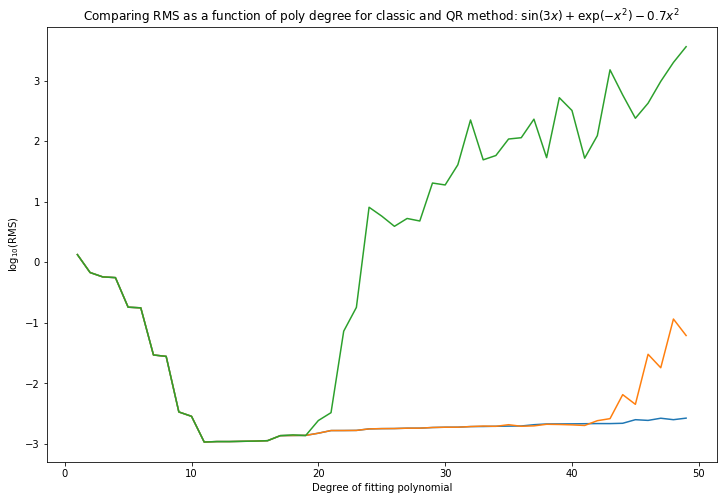

In [294]:
plt.figure(figsize=(12,8))
plt.title("Comparing RMS as a function of poly degree for classic and QR method: " + poly_string)
plt.xlabel("Degree of fitting polynomial")
plt.ylabel("$\log_{10}$(RMS)")
plt.plot(dd, np.log10(QR_rms_vec), "-") # blue line 
plt.plot(dd, np.log10(SVD_rms_vec), "-") # orange line
plt.plot(dd, np.log10(std_rms_vec), "-") # green line 

As shown in the above figure, the blue line (QR) remains stable at high degree while the orange line (SVD) is unstable after about $d=40$, and the green line (standard) is unstable even earlier around $d=20$. 

### Problem 2: Chebyshev polynomials

There are two kinds of Chebyshev polynomials: those of the first kind are solutions to the differential equation shown in Eq. (1) below; those of the second kind are solutions to Eq. (2). 

$ (1-x^{2})y'' - xy' + n^{2}y = 0~~~~~~~~~~~~~~~~~(1)$

$ (1-x^{2})y'' - 3xy' +n(n+2)y = 0~~~~~~(2) $

Here we make use of the Chebyshev polynomials of the first kind, $T_{n}$, which are solutions to (1). These take the form 

$T_{n} = \cos(n\arccos(x)) $

and it can be shown that $T_{n}$ satisfy the following recurrence relation: 

$T_{n+1} = 2xT_{n} - T_{n-1}$ 

with $T_{0}(x) = 1$ and $T_{1}(x) = x$. 

#### a) Fitting Chebyshev polynomials to $\exp(x)$ on $[-1,1]$

When fitting a real function $f(x)$ on a compact interval $[a,b]$ with polynomials one forms the matrix $A$ using code that goes something like 

` for d in range(1,dmax):`
    
    A      = np.zeros([nsamp, d+1])
    A[:,0] = 1.0 # zeroth order term 
    
    for i in range(d): 
        A[:,i+1] = A[:,i]*x 
        
This exemplifies the recurrence relation between monomials: $x_{n} \equiv x^{n} \implies x_{n+1} = x\cdot x_{n}$. To do the same with Chebyshev polynomials $T_{n}$ we can reuse the code from __Problem 1__. 

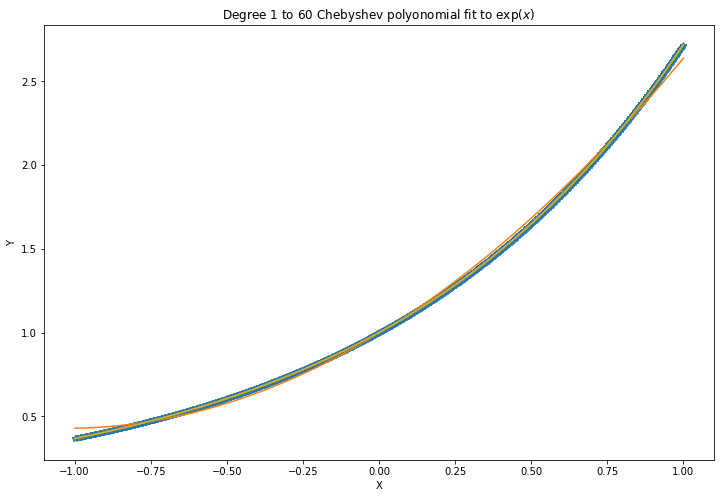

In [227]:
### Problem 2

import numpy as np 
from matplotlib import pyplot as plt 

nsamp  = 1000
left   = -1
right  = 1
x  = np.linspace(left,right,nsamp)

y_true      = np.exp(x)
y_string = "$\exp(x)$" 

noise  = 0 # stationary noise
y      = y_true + np.random.randn(nsamp)*noise

dmax   = 60 # max degree for Chebyshev poly fits 

dd = np.arange(1,dmax,1)

rms_vec = np.zeros(len(dd))

fit_6d  = np.zeros(len(x))
m_6d    = np.zeros(7)
A_6d    = np.zeros([nsamp, 7])

fit_30d = np.zeros(len(x))
m_30d   = np.zeros(31)
A_30d   = np.zeros([nsamp, 31])

plt.figure(figsize=(12,8))
plt.ion()
plt.clf()
plt.title("Degree 1 to " + str(dmax) + " Chebyshev polyonomial fit to " + y_string)
plt.xlabel("X")
plt.ylabel("Y")
plt.plot(x, y, "*")

for d in range(2,dmax):
    
    A = np.zeros([nsamp, d+1])
    A[:,0] = 1.0 # T_0 = 1
    A[:,1] = x   # T_1 = x
    
    for i in range(1, d):
        A[:,i+1] = 2*x*A[:,i] - A[:, i-1]
    
    At    = A.transpose() 
    AtA   = np.dot(At, A)
    AtA_i = np.linalg.inv(AtA)
    
    m_std = np.dot(AtA_i, np.dot(At,y))
    
    chebypoly_fit = np.dot(A, m_std)
    rms           = np.std(chebypoly_fit - y_true)
    rms_vec[d-1]  = rms        
    
    if d==6: 
        fit_6d = chebypoly_fit 
        m_6d   = m_std
        A_6d   = A
    
    if d==30: 
        fit_30d = chebypoly_fit
        m_30d   = m_std
        A_30d   = A 
    
    plt.plot(x, chebypoly_fit, "-")


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


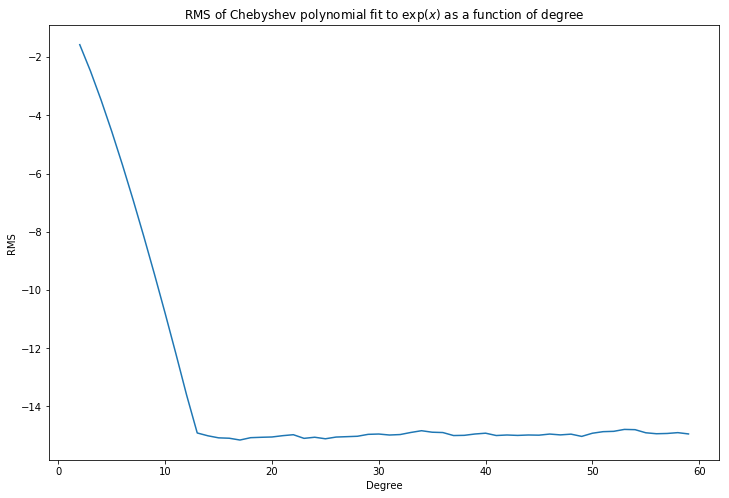

In [213]:
plt.figure(figsize=(12,8))
plt.ion()
plt.clf()
plt.title("RMS of Chebyshev polynomial fit to " + y_string + " as a function of degree")
plt.xlabel("Degree")
plt.ylabel("RMS")
plt.plot(dd, np.log10(rms_vec), "-")

The above plot shows that the RMS of the Chebyshev polynomial fit is stable as the degree of the fitted Chebyshev polynomial increases. 

#### b) Truncating the fit 

The code below calculates the RMS and max error for a 6th degree Chebyshev polynomial fit to $\exp(x)$ on $[-1, 1]$ and compares this to the same values obtained by truncating a 30th degree Chebyshev polynomial fit to the same function on the same interval. 

We find that through truncation, the RMS increases by about 13.8 % while the max error decreases by a factor of about 2.3. Additionally, the maximum error for the full 30th degree fit is about 9 orders of magnitude smaller than the maximum error for the truncated 30th degree fit. 

The important remark to be made here is that fitting with a higher degree Chebyshev polynomial will result in smaller maximum error but likely larger RMS. In this way, they may present themselves as a solution in a context where smaller maximum deviations are desirable. 


In [237]:
r1 = np.std(fit_6d - y_true)
m1 = np.max(np.abs(fit_6d - y_true))
print("Degree 6 RMS: " + str(r1))
print("Degree 6 max error: " + str(m1))
print("")

m_30d_trunc = np.zeros(len(m_30d))

for i in range(7):
    m_30d_trunc[i] = m_30d[i] 
    
trunc_fit = np.dot(A_30d, m_30d_trunc)
    
r2 = np.std(trunc_fit - y_true)
m2 = np.max(np.abs(trunc_fit - y_true))
print("Truncated degree 30 RMS: " + str(r2))
print("Truncated degree 30 max error: " + str(m2))
print("Non-truncated degree 30 max error: " + str(np.max(np.abs(fit_30d - y_true))))
print("")

print("Percentage increase of RMS through truncation: " + str(100*(r2-r1)/r1))
print("Ratio of max errors (6d/trunc): " + str(m1/m2))

Degree 6 RMS: 1.9852969888212255e-06
Degree 6 max error: 7.984807812722039e-06

Truncated degree 30 RMS: 2.2588093761935343e-06
Truncated degree 30 max error: 3.409262366194099e-06
Non-truncated degree 30 max error: 4.884981308350689e-15

Percentage increase of RMS through truncation: 13.776900328383986
Ratio of max errors (6d/trunc): 2.3420924983358824


### Problem 3: Producing random correlated data from random uncorrelated data 

Assume that $N$ is $n\times n$ positive definite and symmetric. To obtain a correlated set of data from uncorrelated set, we can decompose $N$ into a diagonal matrix $M$ consisting of eigenvalues of $N$ via 

$ N = CMC^{T}$ 

where $C$ is the change of basis matrix. Since $N$ is symmetric and positive definite, $C^{-1} = C^{T}$ and hence $C$ is orthogonal meaning that it leaves $\chi^{2}$ invariant. Thus 

$ \chi^{2} = (\mathbf{d}-\mathbf{\mu})^{T}N^{-1}(\mathbf{d}-\mathbf{\mu}),~~~~~~~ \mathbf{d} - \mathbf{\mu} = \mathbf{n} $

$ \chi^{2} = \mathbf{n}^{T}(CMC^{T})^{-1}\mathbf{n} $

$ \chi^{2} = \mathbf{n}^{T}(C^{T})^{-1}M^{-1}C^{-1}\mathbf{n} $

$ \chi^{2} = \mathbf{n}^{T}CM^{-1}C^{T}\mathbf{n} $

$ \chi^{2} = (C^{T}\mathbf{n})^{T}M^{-1}C^{T}\mathbf{n},~~~~~~ C^{T}\mathbf{n} \equiv \mathbf{\eta} $

$ \chi^{2} = \mathbf{\eta}M^{-1}\mathbf{\eta} $

Now $\mathbf{\eta}$ is uncorrelated, so to produce correlated data we can calculate $\mathbf{n} = C\mathbf{\eta}$. Furthermore, we have that $M_{ij} = \langle\eta_{i}\eta_{j}\rangle $ and $M$ is diagonal with the diagonal entries equal to the eigenvalues of $N$, $\mathbf{\lambda} = (\lambda_{i})$. Hence $\lambda_{i} = M_{ii} = \langle\eta_{i}^{2}\rangle$. Lastly, 

$\sigma_{i}^{2} = \langle\eta_{i}^{2}\rangle - (\langle\eta_{i}\rangle)^{2} = \langle\eta_{i}^{2}\rangle $

so when forming $\mathbf{\eta}$ we should pull numbers from a Gaussian distribution with mean value of $0$ and $\sigma_{i} = \sqrt{\lambda_{i}}$.  

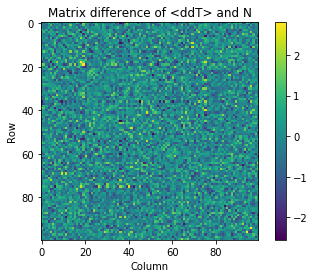

In [59]:
### Problem 3

import numpy as np
from matplotlib import pyplot as plt

num_iter   = 20000

summand    = np.outer(np.zeros(n), np.zeros(n))
avg_nn_nnT = np.outer(np.zeros(n), np.zeros(n))

n = 100
N = np.random.randn(n,n)
N = np.dot(N.transpose(), N)

N = N + np.eye(n)

lam, C = np.linalg.eigh(N) # since N is symmetric and positive definite we use eigh() instead of eig() 

M = np.outer(np.zeros(n), np.zeros(n))

for i in range(n):
    M[i][i] = lam[i]

Ct = C.transpose() 
Mi = np.linalg.inv(M)

eta = np.zeros(n)
nn  = np.zeros(n)

for j in range(num_iter):

    for i in range(n):
        eta[i] = np.random.normal(scale=np.sqrt(lam[i]))

    nn = np.dot(C, eta)
    
    nnT = nn.transpose() 
    
    nn_nnT = np.outer(nn, nnT)
    
    summand += np.outer(nn, nnT)
    
    
avg_nn_nnT = summand/num_iter    
    
#plt.figure(figsize=(12,8))
#plt.title("Plot of <ddT> for " + str(num_iter) + " iterations")
#plt.xlabel("Column")
#plt.ylabel("Row")
#plt.imshow(avg_nn_nnT)
#plt.colorbar()

#plt.figure(figsize=(12,8))
#plt.title("Plot of original noise matrix N")
#plt.xlabel("Column")
#plt.ylabel("Row")
#plt.imshow(N)
#plt.colorbar()

#plt.figure(figsize=(12,8))
plt.title("Matrix difference of <ddT> and N")
plt.xlabel("Column")
plt.ylabel("Row")
plt.imshow(avg_nn_nnT - N)
plt.colorbar()


The above code generates a plot of the matrix $\langle\mathbf{dd}^{T}\rangle - N$ where the average is taken over `num_iter` iterations. At the time of writing, setting `num_iter = 20000` shows the matrix difference is equal to $\mathbb{0}$ within a tolerance of $\pm 3$ which suggests that 

$ \begin{equation} \lim_{k\to\infty}\frac{\sum_{j=1}^{k}(\mathbf{dd}^{T})_{j}}{k} = N \end{equation} $. 

### Problem 4: Using fake correlated noise in fits

#### a) Generating a noise matrix to report error bars on a fit 

Here we experiment with the following noise matrix $N$ defined by 

$ N_{ij} = a\exp\Big{(}-\frac{(i-j)^{2}}{2\sigma^{2}}\Big{)} + (1-a)\delta_{ij} $.

Here, $a \in [0,1] $ controls the degree to which data are correlated: $a=0 \implies N = I$ i.e. data is perfectly uncorrelated; $a=1$ results in "a lot" of correlation. On the other hand, $\sigma$ controls the locality of correlation: large $\sigma$ results in data points being correlated with distant neighbours; small $\sigma$ results in data points being correlated only with adjacent neighbours. 

The goal here is to calculate the best fit amplitude from linear least squares methods, using 

$ m = \frac{A^{T}N^{-1}\mathbf{d}}{A^{T}N^{-1}A} $

To explain the above formula, we note that $N$ is a symmetric $n \times n$ matrix, $A$ is $n \times 1$, $A^{T}$ is $1 \times n$ and hence $m$ is $1\times1$ i.e. a scalar. The error $\sigma_{m}$ is calculated as the square root of the variance of $m$ which is 

$ \sigma_{m} = \sqrt{\langle mm^{T}\rangle} $

The above calculation is straightforward once we observe that $\mathbf{dd}^{T} = N$ and that $A^{T}N^{-1}A$ is a scalar: 

$ \langle mm^{T}\rangle = \langle [(A^{T}N^{-1}A)^{-1}A^{T}N^{-1}\mathbf{d}] [(A^{T}N^{-1}A)^{-1}A^{T}N^{-1}\mathbf{d}]^{T} \rangle $ 

$ \langle mm^{T}\rangle = \langle (A^{T}N^{-1}A)^{-1}A^{T}N^{-1}\mathbf{dd}^{T}(N^{-1})^{T}(A^{T})^{T}[(A^{T}N^{-1}A)^{-1}]^{T} \rangle$

$ \langle mm^{T}\rangle = \langle (A^{T}N^{-1}A)^{-1}A^{T}N^{-1}NN^{-1}A(A^{T}N^{-1}A)^{-1} \rangle$ 

$ \langle mm^{T}\rangle = \langle (A^{T}N^{-1}A)^{-1}A^{T}N^{-1}A(A^{T}N^{-1}A)^{-1} \rangle$ 

$ \langle mm^{T}\rangle = \langle (A^{T}N^{-1}A)^{-1} \rangle$ 

$ \langle mm^{T}\rangle = (A^{T}N^{-1}A)^{-1} $ 

$ \sigma_{m} = \sqrt{(A^{T}N^{-1}A)^{-1}}$ 


In [34]:
### Problem 4 

import numpy as np
from matplotlib import pyplot as plt

sigma = [5, 50, 500]
a     = [0.1, 0.5, 0.9]



l = 0
r = 1000
dx = 1
x = np.arange(l, r, dx) 
lenx = len(x)

musrc     = lenx/2.
sigsrc    = 50.
amp_truth = 1.

def delta(i,j):
    a = i - j
    if a == 0:
        return 1
    else: 
        return 0

print("a \t sigma \t error(m) \n")
    
for k in range(len(sigma)):

    for l in range(len(a)): 
        
        # Initialize the noise matrix 
        N = np.outer(np.zeros(lenx), np.zeros(lenx))
    
        for i in range(lenx):
            for j in range(lenx):
            
                # Generate the noise matrix  
            
                N[i][j] = a[l]*np.exp(-(i-j)**2/(2*sigma[k]**2)) + (1-a[l])*delta(i,j)
    
        # Now generate the data according to Gaussian with amplitude 1, sigma = 50, and mean = 500 
    
        template = np.exp(-(x-musrc)**2/(2*sigsrc**2))
    
        data     = np.dot(N, amp_truth*template)
    
        A        = template 
    
        Ni       = np.linalg.inv(N)
        At       = A.transpose()
    
        NiA      = np.dot(Ni, A)
        AtNiA    = np.dot(At, NiA)
        AtNi     = np.dot(At, Ni)
    
        AtNiA_i  = 1/AtNiA # the denominator is a scalar since we're only fitting the amplitude...
        AtNid    = np.dot(AtNi, data)

        m        = AtNid*AtNiA_i
    
        errm     = np.sqrt(AtNiA_i)
        
        print(str(a[l]) + "\t" + str(sigma[k]) + "\t" + str(errm) + "\n")
   
    

a 	 sigma 	 error(m) 

0.1	5	0.155763354876461

0.5	5	0.2759993508033395

0.9	5	0.35789525996363725

0.1	50	0.3377448956231588

0.5	50	0.7140544770562314

0.9	50	0.9499319468584361

0.1	500	0.12757498758982017

0.5	500	0.10066392140726643

0.9	500	0.04892549466815381



As one can see from the output of the above code, the largest error occurs for the case $a = 0.9$ and $\sigma = 50$; on the other hand, the smallest error occurs for the case $a = 0.9$ and $\sigma = 500$. For $\sigma = 5, 50$ the error on $m$ is proportional to $a$, but for $\sigma = 500$ the error is inversely proportional to $a$. 

In conclusion, the kind of noise that we should be concerned with is that which corresponds to correlated data with a correlation length equal to the source width. If we are estimating the noise matrix by assuming the data is correlated with a correlation length much larger than the source width, this will yield a small error in estimating a fit parameter. 

One could calculate the maximum error analytically by maximizing $\sigma_{m} = \sqrt{(A^{T}N^{-1}A)^{-1}}$ as a function of $a,\sigma$. Multiplying out the matrices yields the following expression, for which one would need to calculate the partial derivatives $\frac{\partial \sigma_{m}}{\partial a}$ and $\frac{\partial \sigma_{m}}{\partial \sigma}$ and set them each to zero:  

$ \sigma_{m} = \Bigg{[} \sum_{k=1}^{n}\sum_{j=1}^{n}\Big{[} a\exp\big{[}-\frac{(k-j)^{2}}{2\sigma^{2}}\big{]} + (1-a)\delta_{kj} \Big{]} \exp\big{[} -\frac{(x_{j}-\mu)^{2} + (x_{k}-\mu)^{2}}{2\sigma_{\text{src}}^{2}} \big{]} \Bigg{]}^{-\tfrac{1}{2}} $ 

Finding the solution to $\frac{\partial \sigma_{m}}{\partial a} = 0$ and $\frac{\partial \sigma_{m}}{\partial \sigma} = 0$ would give the maximum value for $\sigma_{m}$ as a function of $a$ and $\sigma$. One should expect to find that the maximizing values of $a$ and $\sigma$ are such that the noise matrix would represent correlated data with a correlation length equal to the source width. 